# Average text embedding

There are few sentences Embedder, according to advices of some professor averaging words representationsworks well, this notebook implements this problem with the glove word embedder


In [4]:
import numpy as np
import array
import io
import re

In [5]:
def load_stanford(filename):
    """
    edited from : https://github.com/maciejkula/glove-python
    
    Load model from the output files generated by
    the C code from http://nlp.stanford.edu/projects/glove/.
    The entries of the word dictionary will be of type
    unicode in Python 2 and str in Python 3.
    """

    dct = {}
    vectors = array.array('d')

    # Read in the data.
    with io.open(filename, 'r', encoding='utf-8') as savefile:
        for i, line in enumerate(savefile):
            tokens = line.split(' ')

            word = tokens[0]
            entries = tokens[1:]

            dct[word] = i
            vectors.extend(float(x) for x in entries)

    # Infer word vectors dimensions.
    no_components = len(entries)
    no_vectors = len(dct)
    
    vectors = np.reshape( np.asarray(vectors) , (len(dct), len(vectors)/len(dct))) 
    
    return dct, vectors

In [6]:
filename = 'glove.6B/glove.6B.50d.txt'
dct, vectors = load_stanford(filename)

In [7]:
def sentence_to_word_list(sentence):
    word_list = re.compile('\w+').findall(sentence)
    return word_list

def word_list_embedding(word_list, dct, vectors, verbose = True):
    no_words = len(word_list)
    sentence_vector = np.zeros(vectors.shape[1])
    for word in word_list:
        try :
            sentence_vector = sentence_vector + vectors[dct[word.lower()],:]
        except : 
            if verbose : print(word + " is not in dct")
    
    return sentence_vector / no_words

def sentence_embedding(sentence, dct, vectors):
    word_list = sentence_to_word_list(sentence)
    return word_list_embedding(word_list, dct, vectors)

#### an example of embedding

In [9]:
sentence = "my cat... struggles, to find milk !!"
word_list = sentence_to_word_list(sentence)
print(word_list)
print(word_list_embedding(word_list,dct,vectors))

['my', 'cat', 'struggles', 'to', 'find', 'milk']
[ 0.316805    0.01652733 -0.09100133 -0.31091417  0.444893    0.43200917
 -0.50511689  0.08813167  0.25591667  0.10039383  0.084645    0.45822833
  0.024624   -0.07537383  0.55877667  0.33037833 -0.07060433  0.141885
  0.030588   -0.510575   -0.03601     0.29579667  0.38738917  0.21041893
  0.41530067 -1.51271833 -0.60169533  0.10755617  0.675985   -0.329235
  2.62071667  0.557855   -0.39637667  0.121125   -0.09880133  0.12490667
 -0.31955167  0.14460483  0.483944   -0.59042167 -0.09788783 -0.03410983
 -0.18284333  0.286685    0.41040517  0.1583115   0.08037467 -0.36424067
  0.15314233 -0.06182167]


## Network representation of a text

In this part, we take a text, and create a network of its sentences where each node is the representation of a sentence and each edge their semantic similarity

In [10]:
import networkx as nx

In [11]:
def text_to_sentence_list(text) :
    # tokenizer of sentences from a text (take into account multiple punctations issues)
    # and way better than str.split('.')
    return re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<![A-Z]\.)(?<=\.|\?)\s', text)

In [12]:
def create_sim_graph(text, dct, vectors):
    # Works for one document for the moment
    # create a graphe where each node is a sentence, 
    # each edge the similarity weight according to the normalized dot product
    G = nx.Graph()
    
    sentence_list = text_to_sentence_list(text)
    
    for idx, sentence in enumerate(sentence_list):
        G.add_node(idx, sentence = sentence)
        for j in range(idx):
            s_i = sentence_embedding(sentence_list[idx], dct, vectors)
            s_j = sentence_embedding(sentence_list[j], dct, vectors)
            semantic_similarity_ij = np.dot(s_i,s_j) / (np.linalg.norm(s_i)*np.linalg.norm(s_j))
            G.add_edge(idx, j, weight = semantic_similarity_ij) 
    return G

### an example

In [13]:
text = """Mr. Smith bought cheapsite.com for 1.5 million dollars, i.e. he paid a lot for it.
Did he mind?
Adam Jones Jr. thinks he didn't.
In any case, this isn't true...
Well, with a probability of .9 it isn't."""

text_to_sentence_list(text)

['Mr. Smith bought cheapsite.com for 1.5 million dollars, i.e. he paid a lot for it.',
 'Did he mind?',
 "Adam Jones Jr. thinks he didn't.",
 "In any case, this isn't true...",
 "Well, with a probability of .9 it isn't."]

In [14]:
G = create_sim_graph(text, dct, vectors)

cheapsite is not in dct
cheapsite is not in dct
cheapsite is not in dct
cheapsite is not in dct


### Drawings 

#### basic draw

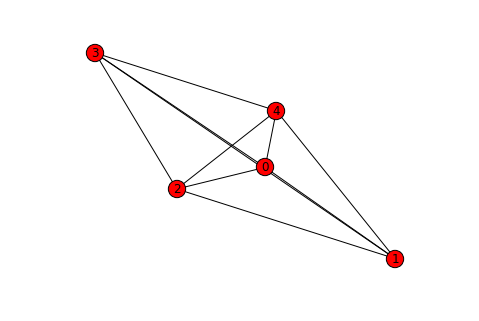

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw(G, with_labels=True)

#### edges colored according to their weight

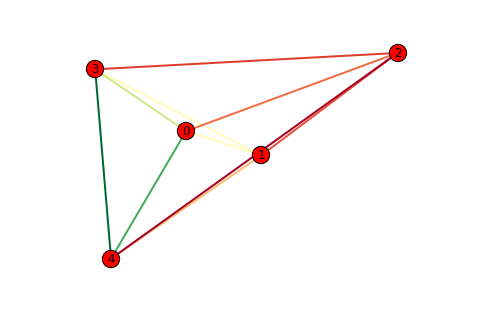

In [16]:
edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())

pos = nx.spring_layout(G)
nx.draw(G, pos, edgelist=edges, edge_color=weights, width=2.0, edge_cmap=plt.cm.RdYlGn, with_labels=True)
#plt.savefig('edges.png')

#### replacing id by sentences

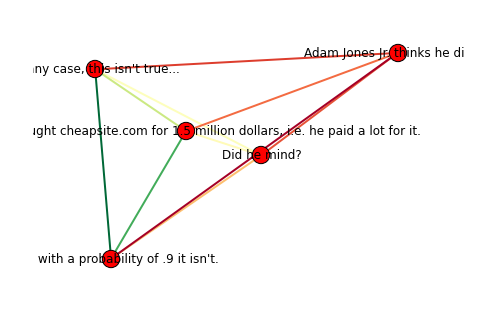

In [21]:
G.nodes()
sentence_list = text_to_sentence_list(text)
labels = {}
for i, item in enumerate(sentence_list):
    labels[i] = sentence_list[i]
    
nx.draw(G, pos, labels=labels, edgelist=edges, edge_color=weights, width=2.0, edge_cmap=plt.cm.RdYlGn, with_labels=True)